# Preparation of data

## Mount drives, import packages, load files

Mount drive

from google.colab import drive                                                                        
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Docencia/art_JDPJ/en_proceso/paper_pedestrians/model/'

In [1]:
base_dir = './'

Importing libraries

In [2]:
#!pip install pycaret
#!pip install haversine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import haversine as hs
from scipy.spatial.distance import cdist
from pycaret.classification import *
from sklearn.neural_network import MLPClassifier


#ignore log(0) and divide by 0 warning
np.seterr(divide = 'ignore');
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# settings to display all columns
pd.set_option("display.max_columns", None)


print('Libraries read!')


Libraries read!


In [3]:
# Loading collisions dataframe
collisions = pd.read_csv(base_dir + 
                      'data/collisions_final.csv'
                      )
print(collisions.shape)
collisions.info()


(27956, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27956 entries, 0 to 27955
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type_road              27956 non-null  object 
 1   weather                27956 non-null  object 
 2   weekend                27956 non-null  object 
 3   night                  27956 non-null  object 
 4   street_use             27956 non-null  object 
 5   number_roads           27956 non-null  object 
 6   number_lanes           27956 non-null  object 
 7   illumination           27956 non-null  object 
 8   traffic_light          27956 non-null  object 
 9   vertical_signals       27956 non-null  object 
 10  horizontal_signals     27956 non-null  object 
 11  visibility             27956 non-null  object 
 12  type_vehicle           27956 non-null  object 
 13  gender                 27956 non-null  object 
 14  month_dry              27956 non-null  obj

## Feature Engineering

In [4]:
collisions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27956 entries, 0 to 27955
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type_road              27956 non-null  object 
 1   weather                27956 non-null  object 
 2   weekend                27956 non-null  object 
 3   night                  27956 non-null  object 
 4   street_use             27956 non-null  object 
 5   number_roads           27956 non-null  object 
 6   number_lanes           27956 non-null  object 
 7   illumination           27956 non-null  object 
 8   traffic_light          27956 non-null  object 
 9   vertical_signals       27956 non-null  object 
 10  horizontal_signals     27956 non-null  object 
 11  visibility             27956 non-null  object 
 12  type_vehicle           27956 non-null  object 
 13  gender                 27956 non-null  object 
 14  month_dry              27956 non-null  object 
 15  hu

In [5]:
collisions.describe(include='all')

,type_road,weather,weekend,night,street_use,number_roads,number_lanes,illumination,traffic_light,vertical_signals,horizontal_signals,visibility,type_vehicle,gender,month_dry,humidity_road,camera_exists,avenue,camera_status,camera_zone,camera_max_speed,camera_road_type,camera_road_hierarchy,camera_lanes,camera_traffic_light,camera_land_use,age,min_dist_m,severity_accident
count,27956,27956,27956,27956,27956,27956,27956,27956,27956,27956,27956,27956,27956,27956,27956,27956,27956,27956,27956,27956,27956,27956,27956,27956,27956,27956,27956.000000,27956.000000,27956
unique,4,2,2,2,3,3,4,2,3,3,3,2,4,2,2,2,2,2,3,9,3,4,4,5,3,4,NaN,NaN,2
top,track_section,dry,no,no,one_way,one_road,two_lanes,good,good,good,inexistent,bad,motorcycle,M,no,dry,False,False,inexistent,inexistent,inexistent,inexistent,inexistent,inexistent,inexistent,inexistent,NaN,NaN,accident
freq,24517,27020,19520,17611,15881,21997,12219,22917,19002,13905,20862,14638,13642,16280,23500,25419,27080,23873,27080,27080,27080,27080,27080,27080,27080,27080,NaN,NaN,27630
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.147446,803.956074,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.326951,674.241275,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,5.410037,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.000000,349.861519,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.000000,551.388818,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.000000,1033.255605,NaN


In [6]:
for i in collisions.drop(columns=['age', 'min_dist_m']).columns:
    print(i, '\n', round(collisions[i].value_counts(normalize=True)*100,1))
    print('-----------------------')

type_road 
 track_section    87.7
intersection      7.0
land_lot          4.5
other             0.8
Name: type_road, dtype: float64
-----------------------
weather 
 dry    96.7
wet     3.3
Name: weather, dtype: float64
-----------------------
weekend 
 no     69.8
yes    30.2
Name: weekend, dtype: float64
-----------------------
night 
 no     63.0
yes    37.0
Name: night, dtype: float64
-----------------------
street_use 
 one_way     56.8
two_ways    36.5
other        6.7
Name: street_use, dtype: float64
-----------------------
number_roads 
 one_road     78.7
two_roads    13.8
other         7.5
Name: number_roads, dtype: float64
-----------------------
number_lanes 
 two_lanes        43.7
one_lane         38.3
several_lanes    12.9
other             5.1
Name: number_lanes, dtype: float64
-----------------------
illumination 
 good    82.0
bad     18.0
Name: illumination, dtype: float64
-----------------------
traffic_light 
 good          68.0
inexistent    31.6
bad            0.5


In [108]:
# Importing module and initialising setup
from pycaret.classification import *
classifier = setup(data = collisions, 
                   target = 'severity_accident', 
                   session_id = 42,
                   normalize = True,
                   use_gpu = True,
                   fold_strategy = 'stratifiedkfold',
                   #transformation=True,
                   ignore_low_variance=True,
                   combine_rare_levels=True,
                   remove_multicollinearity=True,
                   fix_imbalance = True,
                   data_split_stratify = True,
                   silent=True
                   )

,Description,Value
0,session_id,42
1,Target,severity_accident
2,Target Type,Binary
3,Label Encoded,"accident: 0, death: 1"
4,Original Data,"(27956, 29)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,26
8,Ordinal Features,False
9,High Cardinality Features,False


In [11]:
get_config('X')

,age,min_dist_m,type_road_intersection,type_road_land_lot,type_road_other,type_road_track_section,weekend_no,night_no,street_use_one_way,street_use_other,...,horizontal_signals_good,horizontal_signals_inexistent,type_vehicle_bus_truck,type_vehicle_car,type_vehicle_motorcycle,type_vehicle_other,gender_F,month_dry_no,humidity_road_other,avenue_False
0,1.107553,-0.353024,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.152281,-0.544651,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,1.197010,-0.775988,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,-0.771049,-0.270762,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,-0.771049,-0.270762,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27951,0.481352,-0.434637,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
27952,1.957397,-1.020365,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
27953,-1.352521,1.858946,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
27954,0.391895,0.267446,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


## Machine Learning models

In [9]:
# Setting up Artificial Neural Network model
ann = create_model(MLPClassifier(early_stopping=True, max_iter=1000))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9642,0.6484,0.1818,0.0714,0.1026,0.0878,0.0980
1,0.9709,0.7567,0.2174,0.1136,0.1493,0.1359,0.1434
2,0.9576,0.6569,0.0870,0.0312,0.0460,0.0292,0.0333
3,0.9632,0.6294,0.1304,0.0545,0.0769,0.0614,0.0675
4,0.9627,0.5984,0.1739,0.0690,0.0988,0.0833,0.0928
5,0.9709,0.7539,0.1304,0.0750,0.0952,0.0815,0.0848
6,0.9734,0.6528,0.1304,0.0857,0.1034,0.0905,0.0926
7,0.9596,0.7423,0.0870,0.0333,0.0482,0.0317,0.0356
8,0.9612,0.6758,0.1304,0.0508,0.0732,0.0572,0.0640
9,0.9688,0.7466,0.2727,0.1176,0.1644,0.1510,0.1651


In [13]:
best_models = compare_models(include=['qda', 'nb', 'lda', 'lr', 'ada', 'knn', 'gbc', 'dt', 'et', 'rf', 'lightgbm', 'catboost', ann], sort='recall', turbo=True) 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Quadratic Discriminant Analysis,0.0120,0.4979,0.9955,0.0116,0.0229,-0.0001,-0.0069,0.1360
1,Naive Bayes,0.5839,0.7049,0.7330,0.0212,0.0412,0.0190,0.0702,0.0390
3,Logistic Regression,0.7328,0.7534,0.6626,0.0284,0.0545,0.0329,0.0955,0.6230
2,Linear Discriminant Analysis,0.7305,0.7568,0.6542,0.0278,0.0533,0.0317,0.0926,0.2370
5,K Neighbors Classifier,0.9270,0.6318,0.2593,0.0439,0.0749,0.0561,0.0818,1.1620
4,Ada Boost Classifier,0.9204,0.7330,0.2372,0.0378,0.0651,0.0460,0.0683,1.2120
12,MLP Classifier,0.9653,0.6861,0.1542,0.0702,0.0958,0.0810,0.0877,63.9800
6,Gradient Boosting Classifier,0.9596,0.7349,0.1405,0.0495,0.0728,0.0568,0.0654,5.0480
7,Decision Tree Classifier,0.9705,0.5300,0.0791,0.0470,0.0586,0.0447,0.0464,0.1930
8,Extra Trees Classifier,0.9826,0.6990,0.0664,0.1042,0.0802,0.0720,0.0743,1.0360


### Linear Discriminant Analysis

In [15]:
# Linear Discriminant Analysis
lda = create_model('lda')
print(lda)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7312,0.7249,0.6364,0.0263,0.0505,0.0296,0.0874
1,0.7404,0.7388,0.5652,0.0254,0.0487,0.0268,0.0755
2,0.7220,0.8081,0.6957,0.0289,0.0556,0.0338,0.1000
3,0.7353,0.7238,0.6087,0.0268,0.0513,0.0294,0.0841
4,0.7409,0.6946,0.4783,0.0217,0.0416,0.0195,0.0547
5,0.7312,0.7593,0.6522,0.0281,0.0540,0.0321,0.0930
6,0.7287,0.7686,0.6522,0.0279,0.0535,0.0316,0.0921
7,0.7154,0.7584,0.7826,0.0316,0.0607,0.0390,0.1179
8,0.7420,0.7499,0.6522,0.0293,0.0561,0.0344,0.0969
9,0.7178,0.8415,0.8182,0.0318,0.0612,0.0404,0.1244


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)


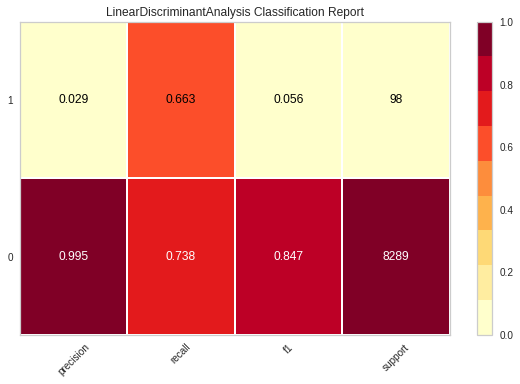

In [16]:
  # Plotting the classification report
plot_model(estimator = lda, plot = 'class_report')

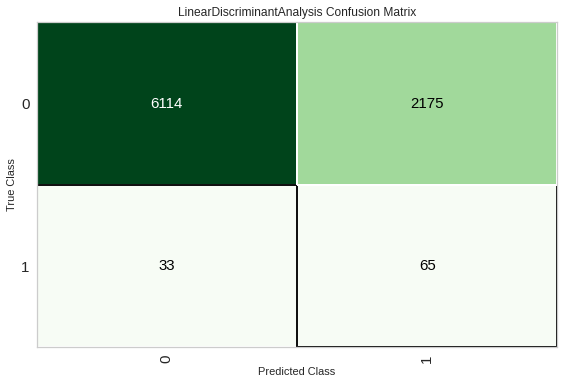

In [17]:
# Plotting the confusion matrix
plot_model(estimator = lda, plot = 'confusion_matrix')

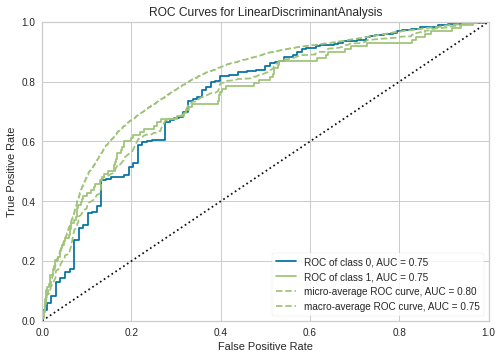

In [18]:
# Plotting the AUC
plot_model(estimator = lda, plot = 'auc')


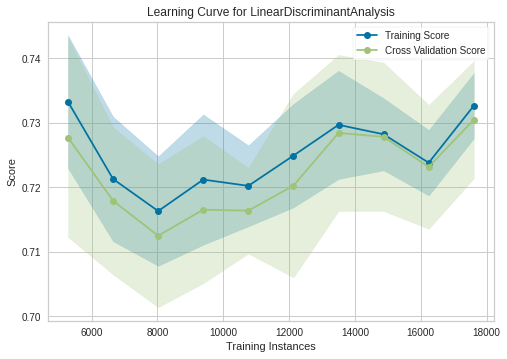

In [19]:
# Plotting the learning curve
plot_model(estimator = lda, plot = 'learning' )

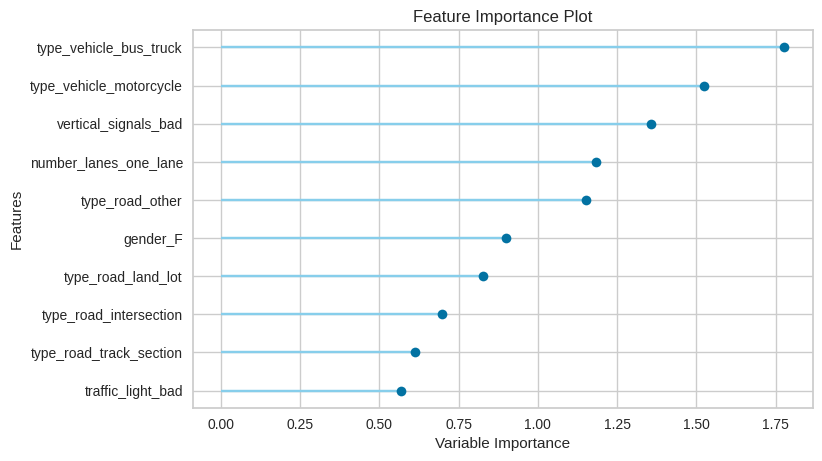

In [20]:
# Plotting the feature importance
plot_model(estimator = lda, plot = 'feature')

In [23]:
get_config('X_train')

,age,min_dist_m,type_road_intersection,type_road_land_lot,type_road_other,type_road_track_section,weekend_no,night_no,street_use_one_way,street_use_other,...,horizontal_signals_good,horizontal_signals_inexistent,type_vehicle_bus_truck,type_vehicle_car,type_vehicle_motorcycle,type_vehicle_other,gender_F,month_dry_no,humidity_road_other,avenue_False
25526,-0.144849,-0.839907,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
23346,-0.055391,-0.677924,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
5464,-0.726321,0.561604,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4745,1.197010,-0.677924,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
23101,-0.815778,1.113832,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14106,-1.486707,1.886223,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
10748,-1.397250,-0.439216,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
9989,0.839181,-0.108282,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
7579,0.391895,2.149035,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


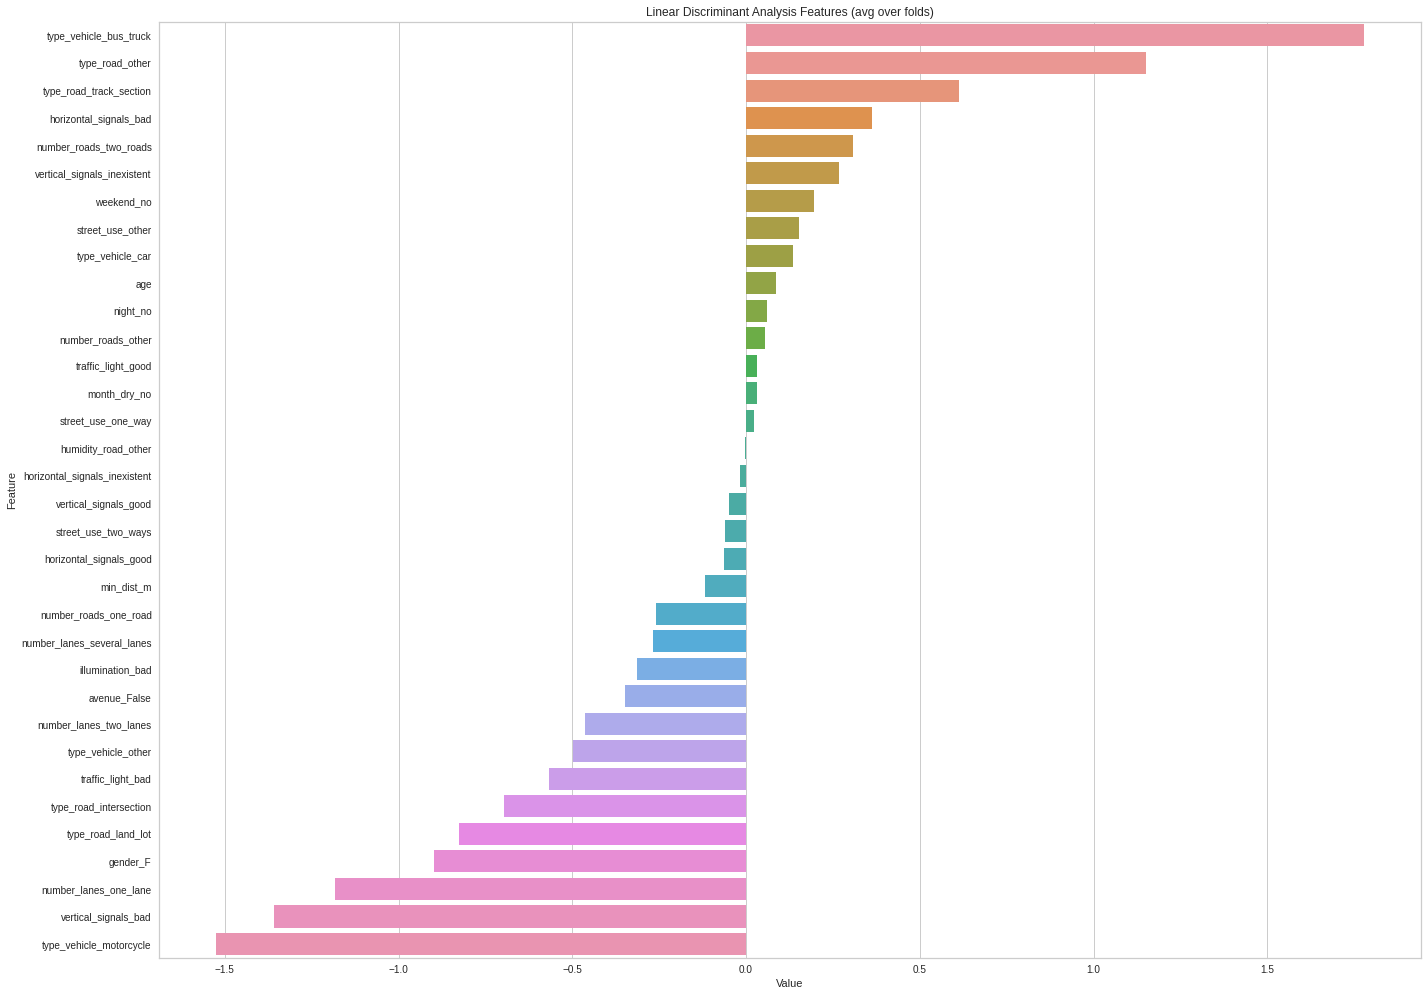

In [24]:
# interpreting model
feature_imp_lda = pd.DataFrame(sorted(zip(lda.coef_[0],get_config('X_train').columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 14))
sns.barplot(x="Value", y="Feature", data=feature_imp_lda.sort_values(by="Value", ascending=False))
plt.title('Linear Discriminant Analysis Features (avg over folds)')
plt.tight_layout()
plt.show()

In [25]:
# Plotting the model hyperparameter
plot_model(estimator = lda, plot = 'parameter')

,Parameters
n_components,None
priors,None
shrinkage,None
solver,svd
store_covariance,False
tol,0.0001


### Tuned Linear Discriminant Analysis

In [26]:
# tune hyperparameters to optimize AUC
tuned_lda = tune_model(lda, optimize = 'AUC', n_iter=80) #default is 'Accuracy'

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7333,0.7526,0.7273,0.0301,0.0578,0.0370,0.1091
1,0.7363,0.7550,0.5652,0.0250,0.0480,0.0260,0.0741
2,0.7174,0.8228,0.7391,0.0301,0.0579,0.0362,0.1086
3,0.7394,0.7499,0.6087,0.0272,0.0520,0.0302,0.0856
4,0.7384,0.7056,0.5217,0.0234,0.0448,0.0228,0.0644
5,0.7236,0.7581,0.6522,0.0274,0.0525,0.0307,0.0904
6,0.7261,0.7659,0.6522,0.0276,0.0530,0.0312,0.0913
7,0.7138,0.7664,0.7826,0.0314,0.0604,0.0387,0.1174
8,0.7302,0.7444,0.5652,0.0245,0.0469,0.0250,0.0721
9,0.7152,0.8421,0.8182,0.0315,0.0607,0.0399,0.1235


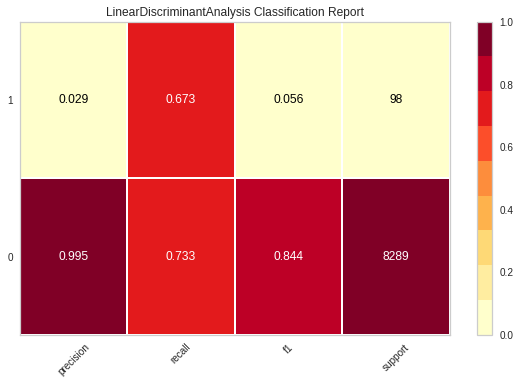

In [27]:
# Plotting the classification report
plot_model(estimator = tuned_lda, plot = 'class_report')

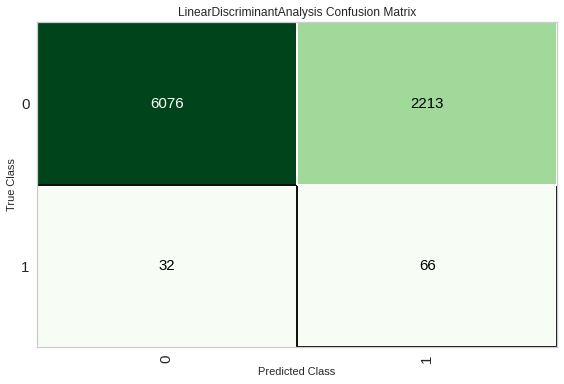

In [28]:
# Plotting the confusion matrix
plot_model(estimator = tuned_lda, plot = 'confusion_matrix')

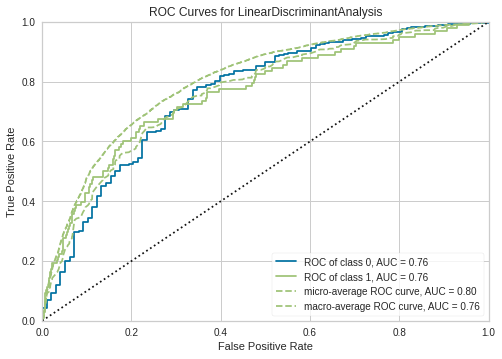

In [29]:
# Plotting the AUC
plot_model(estimator = tuned_lda, plot = 'auc')


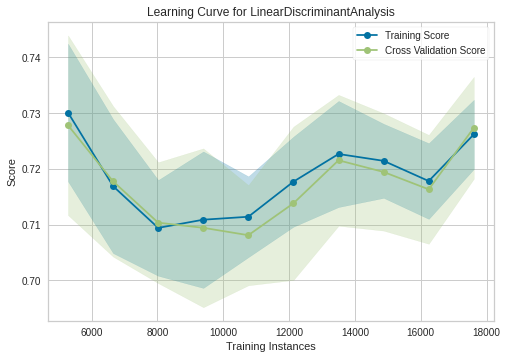

In [30]:
# Plotting the learning curve
plot_model(estimator = tuned_lda, plot = 'learning')

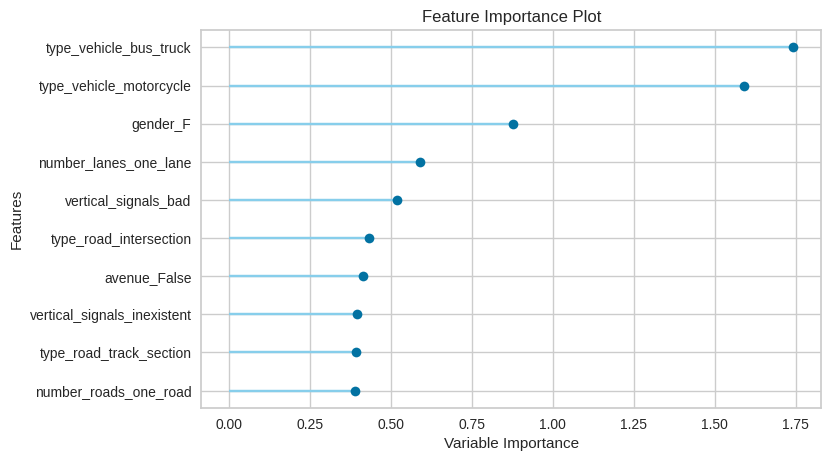

In [31]:
# Plotting the feature importance
plot_model(estimator = tuned_lda, plot = 'feature')

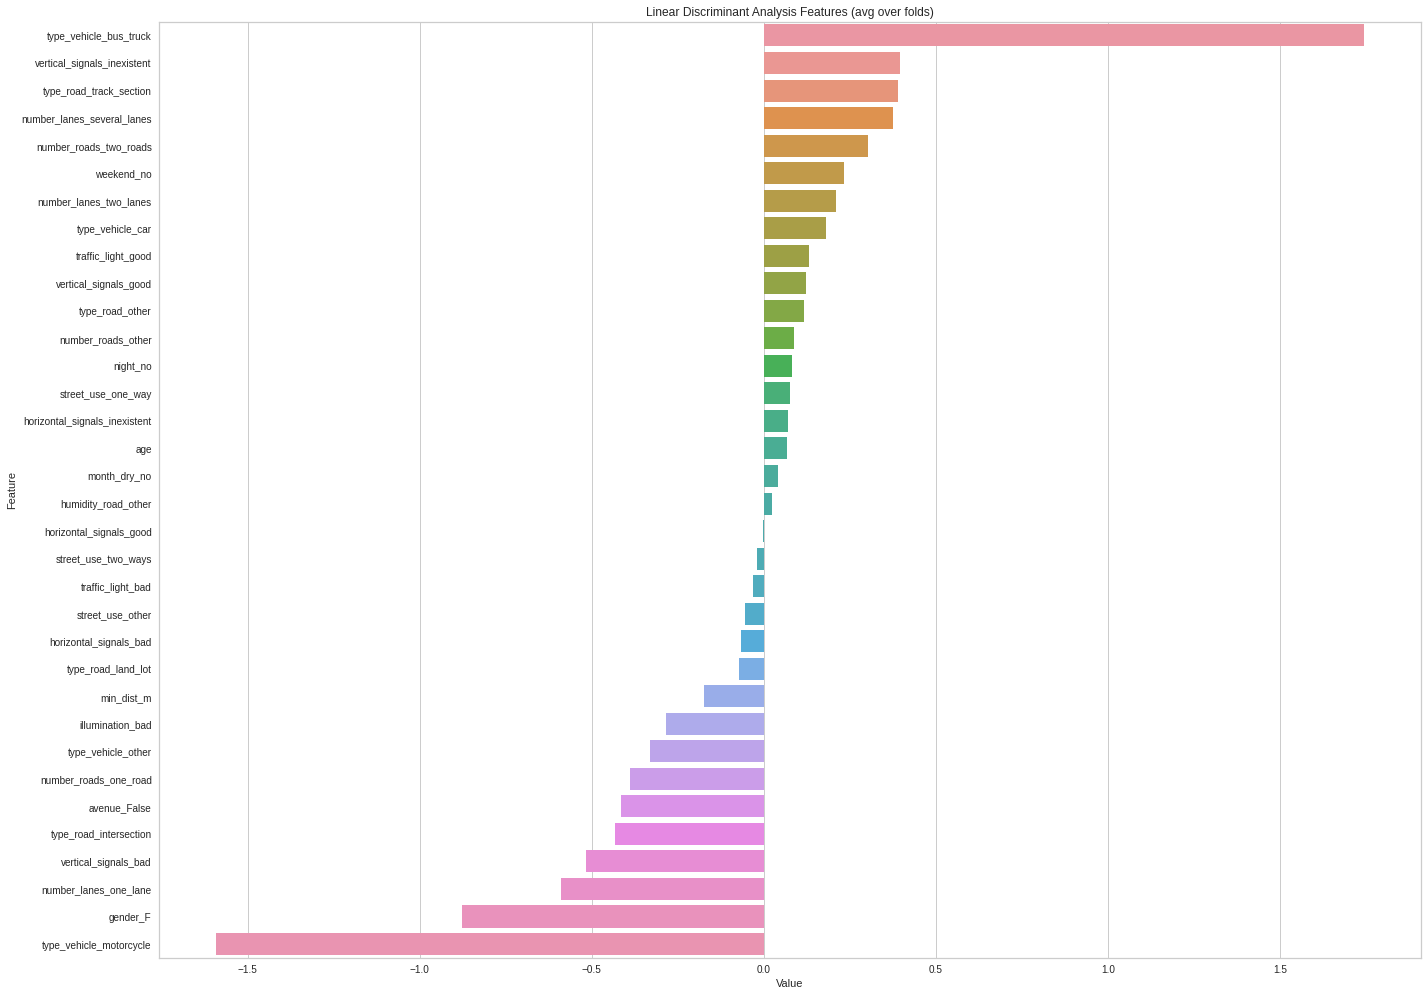

In [33]:
# interpreting model
feature_imp_tuned_lda = pd.DataFrame(sorted(zip(tuned_lda.coef_[0],get_config('X_train').columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 14))
sns.barplot(x="Value", y="Feature", data=feature_imp_tuned_lda.sort_values(by="Value", ascending=False))
plt.title('Linear Discriminant Analysis Features (avg over folds)')
plt.tight_layout()
plt.show()

In [42]:
np.sort(tuned_lda.coef_[0], axis=0)

array([-1.5912454 , -0.8776059 , -0.58823013, -0.51755905, -0.43256855,
       -0.41435054, -0.38896865, -0.33063075, -0.28337535, -0.17411557,
       -0.07379513, -0.06677878, -0.055074  , -0.03088269, -0.02131533,
       -0.00391524,  0.0235409 ,  0.04121551,  0.06790519,  0.07069402,
        0.07638933,  0.08225083,  0.08687936,  0.11601394,  0.12245663,
        0.13147181,  0.17944011,  0.20791708,  0.23218721,  0.30208927,
        0.375981  ,  0.39034975,  0.39510244,  1.742436  ], dtype=float32)

In [59]:
tuned_lda_coef_reduced = np.array([
                                   np.sort(tuned_lda.coef_[0], axis=0)[-1], np.sort(tuned_lda.coef_[0], axis=0)[-2], np.sort(tuned_lda.coef_[0], axis=0)[-3],
                                   np.sort(tuned_lda.coef_[0], axis=0)[2], np.sort(tuned_lda.coef_[0], axis=0)[1], np.sort(tuned_lda.coef_[0], axis=0)[0]
                                   ])
tuned_lda_coef_reduced

array([ 1.742436  ,  0.39510244,  0.39034975, -0.58823013, -0.8776059 ,
       -1.5912454 ], dtype=float32)

In [60]:
columns_for_visualizing = get_config('X_train')[[
                                          'type_vehicle_bus_truck', 'vertical_signals_inexistent', 'type_road_track_section',
                                           'number_lanes_one_lane', 'gender_F', 'type_vehicle_motorcycle'
                                          ]]
columns_for_visualizing.columns

Index(['type_vehicle_bus_truck', 'vertical_signals_inexistent',
       'type_road_track_section', 'number_lanes_one_lane', 'gender_F',
       'type_vehicle_motorcycle'],
      dtype='object')

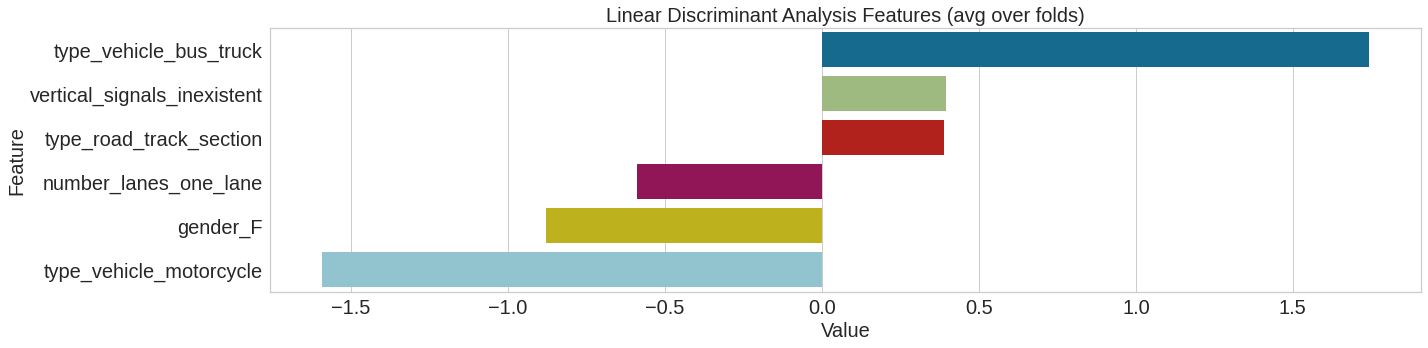

In [61]:
# interpreting model_reduced
feature_imp_tuned_lda_reduced = pd.DataFrame(sorted(zip(tuned_lda_coef_reduced,columns_for_visualizing.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp_tuned_lda_reduced.sort_values(by="Value", ascending=False))
plt.title('Linear Discriminant Analysis Features (avg over folds)', size = 20)
plt.xlabel('Value', size = 20)
plt.ylabel('Feature', size = 20)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.tight_layout()
plt.show()

In [62]:
# Plotting the model hyperparameter
plot_model(estimator = tuned_lda, plot = 'parameter')

,Parameters
n_components,None
priors,None
shrinkage,0.3
solver,lsqr
store_covariance,False
tol,0.0001


### Logistic Regression

In [63]:
# Logistic Regression
lr=create_model('lr')
print(lr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7368,0.7108,0.6364,0.0269,0.0516,0.0307,0.0893
1,0.7409,0.7308,0.5652,0.0255,0.0488,0.0269,0.0757
2,0.7230,0.8085,0.7391,0.0307,0.0590,0.0373,0.1106
3,0.7399,0.7205,0.6522,0.0291,0.0557,0.0339,0.0962
4,0.7460,0.6900,0.5217,0.0241,0.0461,0.0241,0.0669
5,0.7312,0.7624,0.6522,0.0281,0.0540,0.0321,0.0930
6,0.7384,0.7624,0.6957,0.0307,0.0588,0.0371,0.1060
7,0.7169,0.7619,0.7826,0.0317,0.0610,0.0393,0.1185
8,0.7353,0.7500,0.6087,0.0268,0.0513,0.0294,0.0841
9,0.7198,0.8368,0.7727,0.0304,0.0584,0.0376,0.1148


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


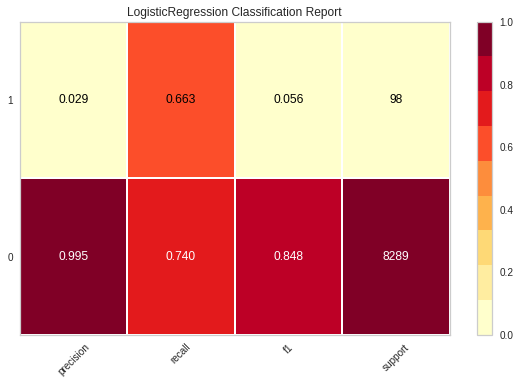

In [64]:
# Plotting the classification report
plot_model(estimator = lr, plot = 'class_report')

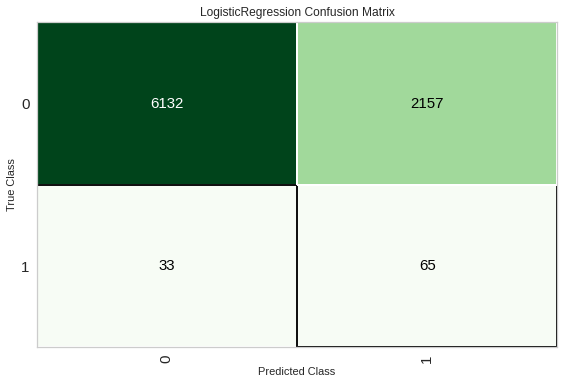

In [65]:
# Plotting the confusion matrix
plot_model(estimator = lr, plot = 'confusion_matrix')

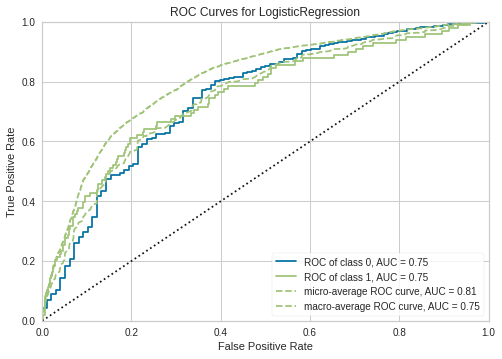

In [66]:
# Plotting the AUC
plot_model(estimator = lr, plot = 'auc')


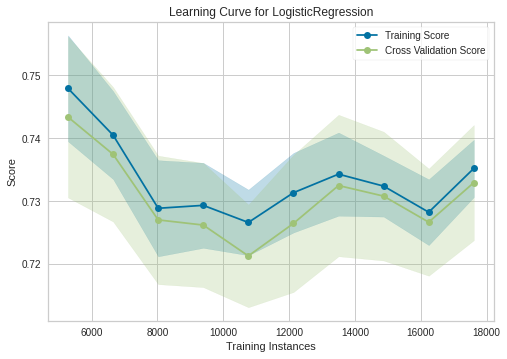

In [67]:
# Plotting the learning curve
plot_model(estimator = lr, plot = 'learning')

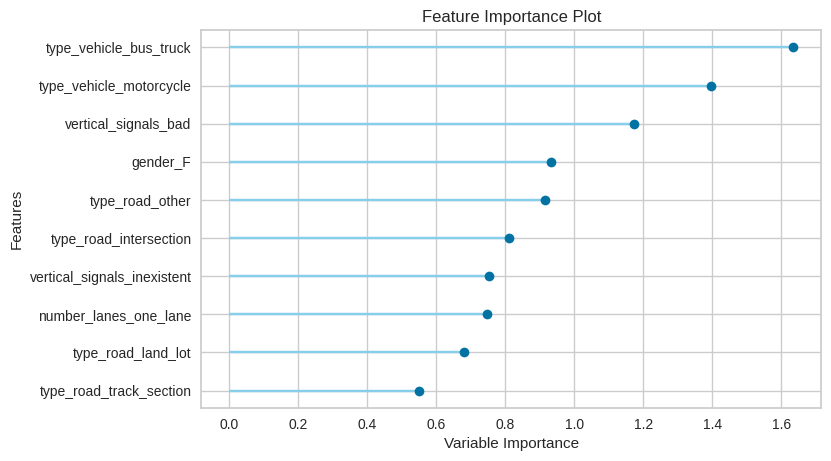

In [68]:
# Plotting the feature importance
plot_model(estimator = lr, plot = 'feature')

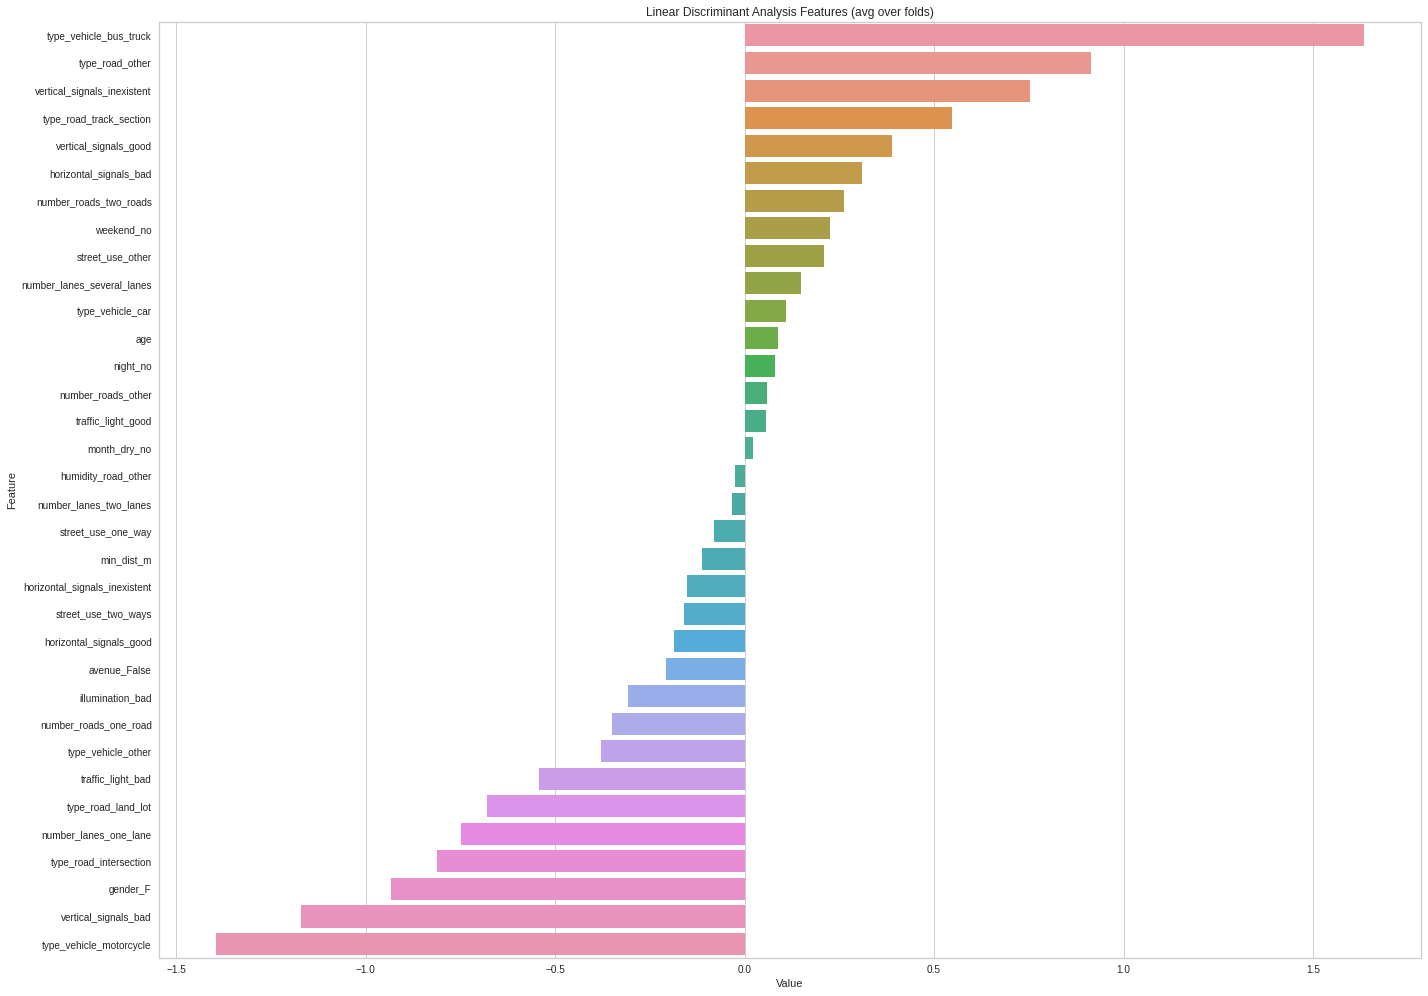

In [69]:
# interpreting model
feature_imp_lr = pd.DataFrame(sorted(zip(lr.coef_[0],get_config('X_train').columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 14))
sns.barplot(x="Value", y="Feature", data=feature_imp_lr.sort_values(by="Value", ascending=False))
plt.title('Linear Discriminant Analysis Features (avg over folds)')
plt.tight_layout()
plt.show()

In [70]:
# Plotting the model hyperparameter
plot_model(estimator = lr, plot = 'parameter')

,Parameters
C,1.0
class_weight,None
dual,False
fit_intercept,True
intercept_scaling,1
l1_ratio,None
max_iter,1000
multi_class,auto
n_jobs,None
penalty,l2


### Tuned Logistic Regression

In [71]:
# tune hyperparameters to optimize AUC
tuned_lr = tune_model(lr, optimize = 'AUC', n_iter=80) #default is 'Accuracy'

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7389,0.7345,0.6364,0.0271,0.0519,0.0311,0.0900
1,0.7420,0.7320,0.5652,0.0256,0.0490,0.0271,0.0760
2,0.7236,0.8100,0.7391,0.0308,0.0591,0.0374,0.1108
3,0.7394,0.7252,0.6522,0.0290,0.0556,0.0338,0.0960
4,0.7460,0.6914,0.5217,0.0241,0.0461,0.0241,0.0669
5,0.7312,0.7624,0.6522,0.0281,0.0540,0.0321,0.0930
6,0.7374,0.7627,0.6957,0.0306,0.0586,0.0369,0.1056
7,0.7174,0.7627,0.7826,0.0318,0.0611,0.0394,0.1187
8,0.7353,0.7511,0.6087,0.0268,0.0513,0.0294,0.0841
9,0.7193,0.8380,0.7727,0.0303,0.0583,0.0375,0.1146


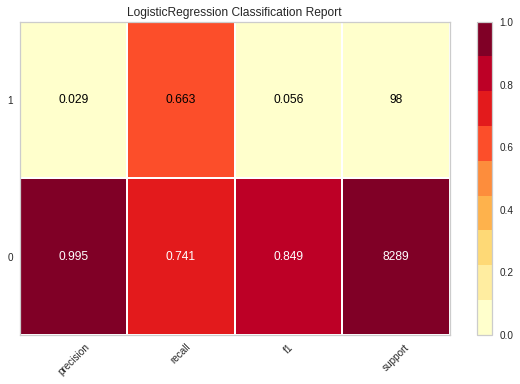

In [72]:
# Plotting the classification report
plot_model(estimator = tuned_lr, plot = 'class_report')

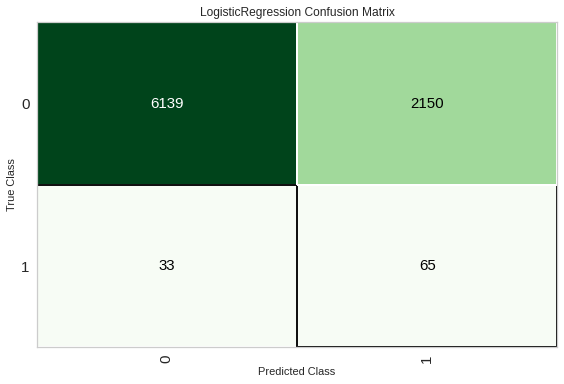

In [73]:
# Plotting the confusion matrix
plot_model(estimator = tuned_lr, plot = 'confusion_matrix')

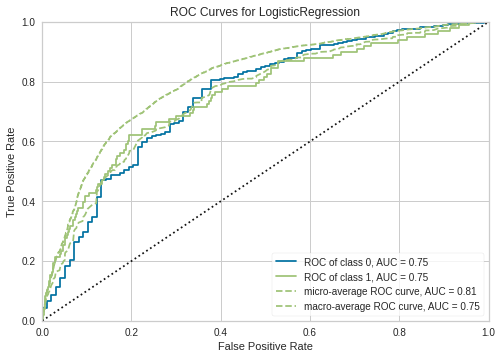

In [74]:
# Plotting the AUC
plot_model(estimator = tuned_lr, plot = 'auc')


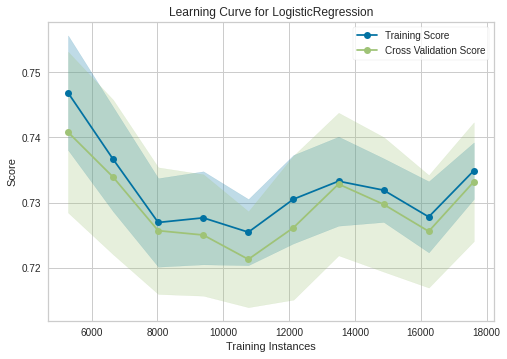

In [75]:
# Plotting the learning curve
plot_model(estimator = tuned_lr, plot = 'learning')

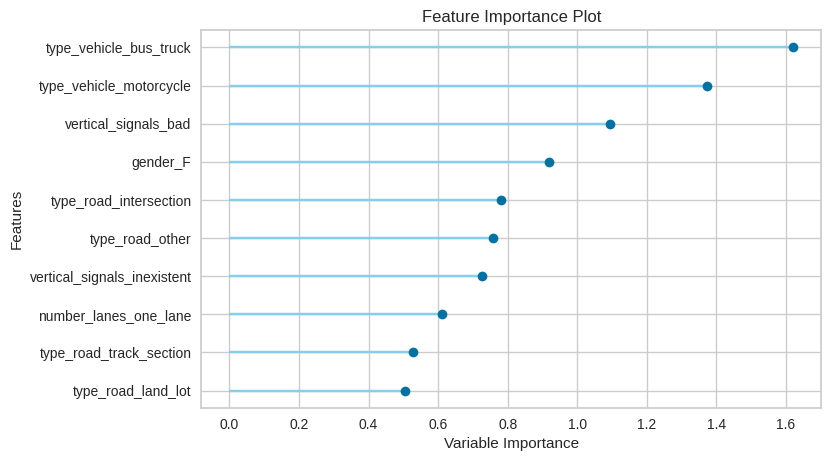

In [76]:
# Plotting the feature importance
plot_model(estimator = tuned_lr, plot = 'feature')

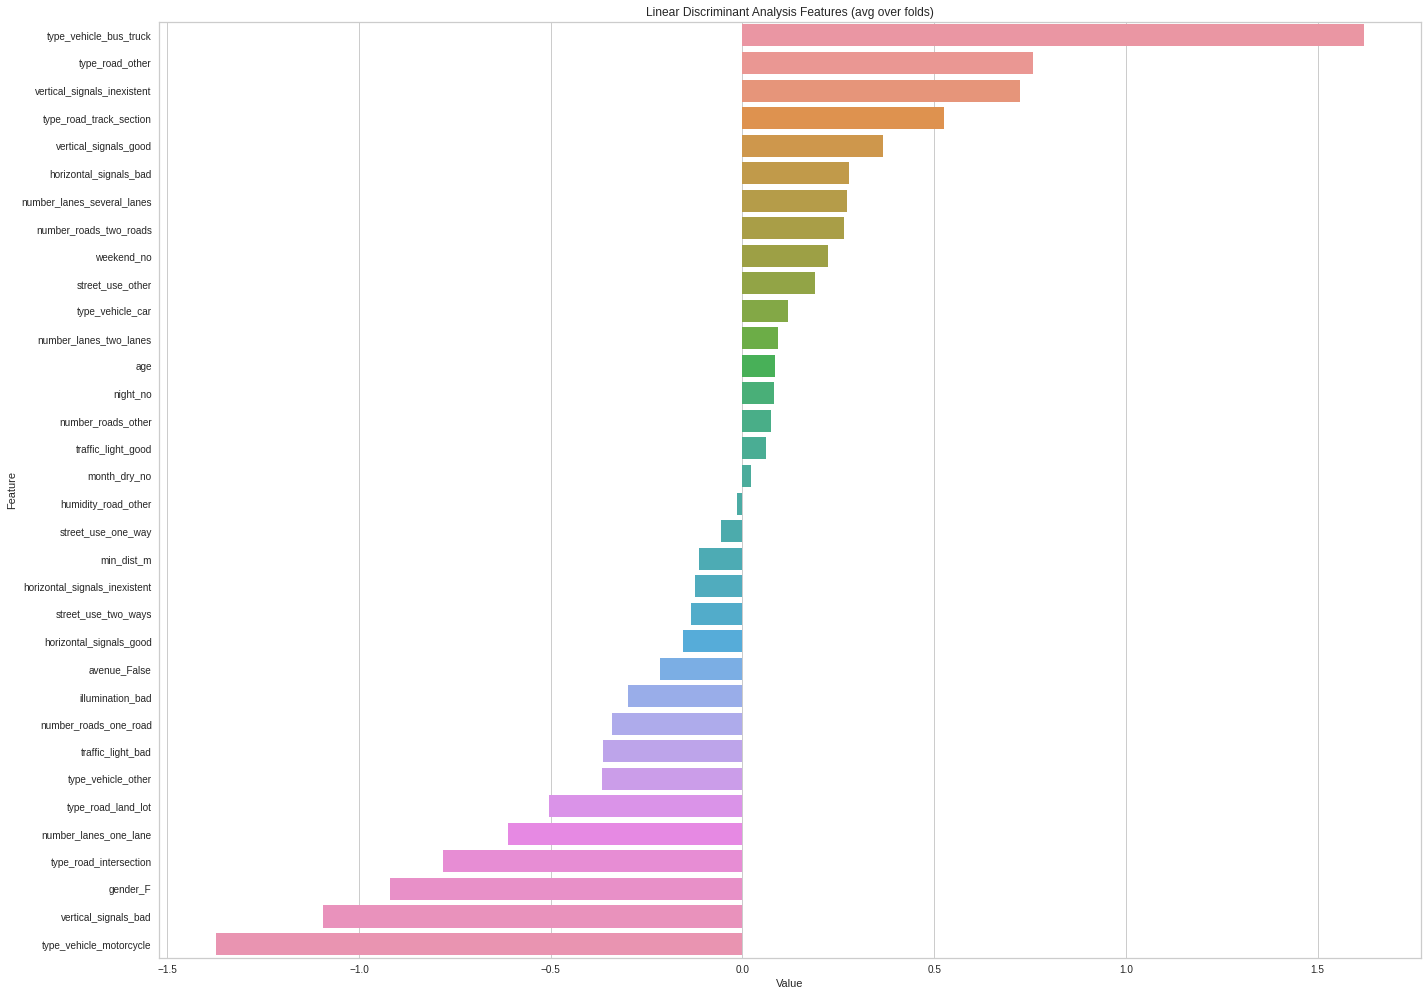

In [77]:
# interpreting model
feature_imp_tuned_lr = pd.DataFrame(sorted(zip(tuned_lr.coef_[0],get_config('X_train').columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 14))
sns.barplot(x="Value", y="Feature", data=feature_imp_tuned_lr.sort_values(by="Value", ascending=False))
plt.title('Linear Discriminant Analysis Features (avg over folds)')
plt.tight_layout()
plt.show()

In [78]:
# Plotting the model hyperparameter
plot_model(estimator = tuned_lr, plot = 'parameter')

,Parameters
C,0.081
class_weight,{}
dual,False
fit_intercept,True
intercept_scaling,1
l1_ratio,None
max_iter,1000
multi_class,auto
n_jobs,None
penalty,l2


### Conclusions about models

tuned_LDA is chosen...

## Predictions

In [79]:
predictions = predict_model(tuned_lda, data = collisions)
predictions_real_severity = predictions.pop('severity_accident')
predictions.insert(loc=28, column='severity_accident', value=predictions_real_severity)
predictions.head()

,type_road,weather,weekend,night,street_use,number_roads,number_lanes,illumination,traffic_light,vertical_signals,...,camera_road_type,camera_road_hierarchy,camera_lanes,camera_traffic_light,camera_land_use,age,min_dist_m,severity_accident,Label,Score
0,track_section,dry,no,no,two_ways,one_road,two_lanes,good,good,inexistent,...,inexistent,inexistent,inexistent,inexistent,inexistent,60.0,564.166841,accident,death,0.5083
1,track_section,dry,yes,no,one_way,one_road,one_lane,good,good,inexistent,...,inexistent,inexistent,inexistent,inexistent,inexistent,61.0,434.878427,accident,accident,0.8472
2,track_section,dry,yes,no,one_way,one_road,several_lanes,good,good,inexistent,...,inexistent,inexistent,inexistent,inexistent,inexistent,62.0,278.798323,accident,accident,0.6694
3,track_section,dry,no,no,one_way,one_road,two_lanes,good,good,inexistent,...,inexistent,inexistent,inexistent,inexistent,inexistent,18.0,619.667816,accident,accident,0.7033
4,track_section,dry,no,no,one_way,one_road,two_lanes,good,good,inexistent,...,inexistent,inexistent,inexistent,inexistent,inexistent,18.0,619.667816,accident,accident,0.7033


In [80]:
## Predictions for real deaths

# Filtering
collisions_deaths = collisions[(collisions.severity_accident == 'death')]
collisions_deaths.reset_index(drop=True, inplace=True)


# Predicting
predictions_deaths = predict_model(tuned_lda, data = collisions_deaths)

predictions_real_death = predictions_deaths.pop('severity_accident')

predictions_deaths.insert(loc=28, column='severity_accident', value=predictions_real_death)
predictions_deaths.head()

,type_road,weather,weekend,night,street_use,number_roads,number_lanes,illumination,traffic_light,vertical_signals,...,camera_road_type,camera_road_hierarchy,camera_lanes,camera_traffic_light,camera_land_use,age,min_dist_m,severity_accident,Label,Score
0,track_section,dry,no,no,one_way,one_road,one_lane,good,good,inexistent,...,inexistent,inexistent,inexistent,inexistent,inexistent,31.0,590.598346,death,accident,0.9234
1,track_section,dry,yes,no,one_way,two_roads,several_lanes,good,inexistent,inexistent,...,inexistent,inexistent,inexistent,inexistent,inexistent,76.0,380.873948,death,death,0.8182
2,track_section,dry,yes,yes,one_way,one_road,two_lanes,good,inexistent,inexistent,...,inexistent,inexistent,inexistent,inexistent,inexistent,25.0,629.934267,death,death,0.8810
3,track_section,dry,no,yes,one_way,one_road,one_lane,good,inexistent,inexistent,...,inexistent,inexistent,inexistent,inexistent,inexistent,11.0,344.960989,death,death,0.8191
4,track_section,dry,no,no,two_ways,two_roads,several_lanes,good,good,inexistent,...,inexistent,inexistent,inexistent,inexistent,inexistent,59.0,67.640404,death,death,0.9130


## Saving the model

In [81]:
# save a model
final_tuned_lda = finalize_model(tuned_lda)
save_model(tuned_lda, base_dir + 'models/tuned_lda_full')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='severity_accident',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 n...
                 ('fix_multi',
                  Fix_multicollinearity(correlation_with_target_preference=None,
                                        correlation_with_target_threshold=0.0,
                                        targ

# Plotting feature importance, in order

In [85]:
tuned_lda.coef_[0]

array([ 0.06790519, -0.17411557, -0.43256855, -0.07379513,  0.11601394,
        0.39034975,  0.23218721,  0.08225083,  0.07638933, -0.055074  ,
       -0.02131533, -0.38896865,  0.08687936,  0.30208927, -0.58823013,
        0.375981  ,  0.20791708, -0.28337535, -0.03088269,  0.13147181,
       -0.51755905,  0.12245663,  0.39510244, -0.06677878, -0.00391524,
        0.07069402,  1.742436  ,  0.17944011, -1.5912454 , -0.33063075,
       -0.8776059 ,  0.04121551,  0.0235409 , -0.41435054], dtype=float32)

In [84]:
get_config('X_train').columns

Index(['age', 'min_dist_m', 'type_road_intersection', 'type_road_land_lot',
       'type_road_other', 'type_road_track_section', 'weekend_no', 'night_no',
       'street_use_one_way', 'street_use_other', 'street_use_two_ways',
       'number_roads_one_road', 'number_roads_other', 'number_roads_two_roads',
       'number_lanes_one_lane', 'number_lanes_several_lanes',
       'number_lanes_two_lanes', 'illumination_bad', 'traffic_light_bad',
       'traffic_light_good', 'vertical_signals_bad', 'vertical_signals_good',
       'vertical_signals_inexistent', 'horizontal_signals_bad',
       'horizontal_signals_good', 'horizontal_signals_inexistent',
       'type_vehicle_bus_truck', 'type_vehicle_car', 'type_vehicle_motorcycle',
       'type_vehicle_other', 'gender_F', 'month_dry_no', 'humidity_road_other',
       'avenue_False'],
      dtype='object')

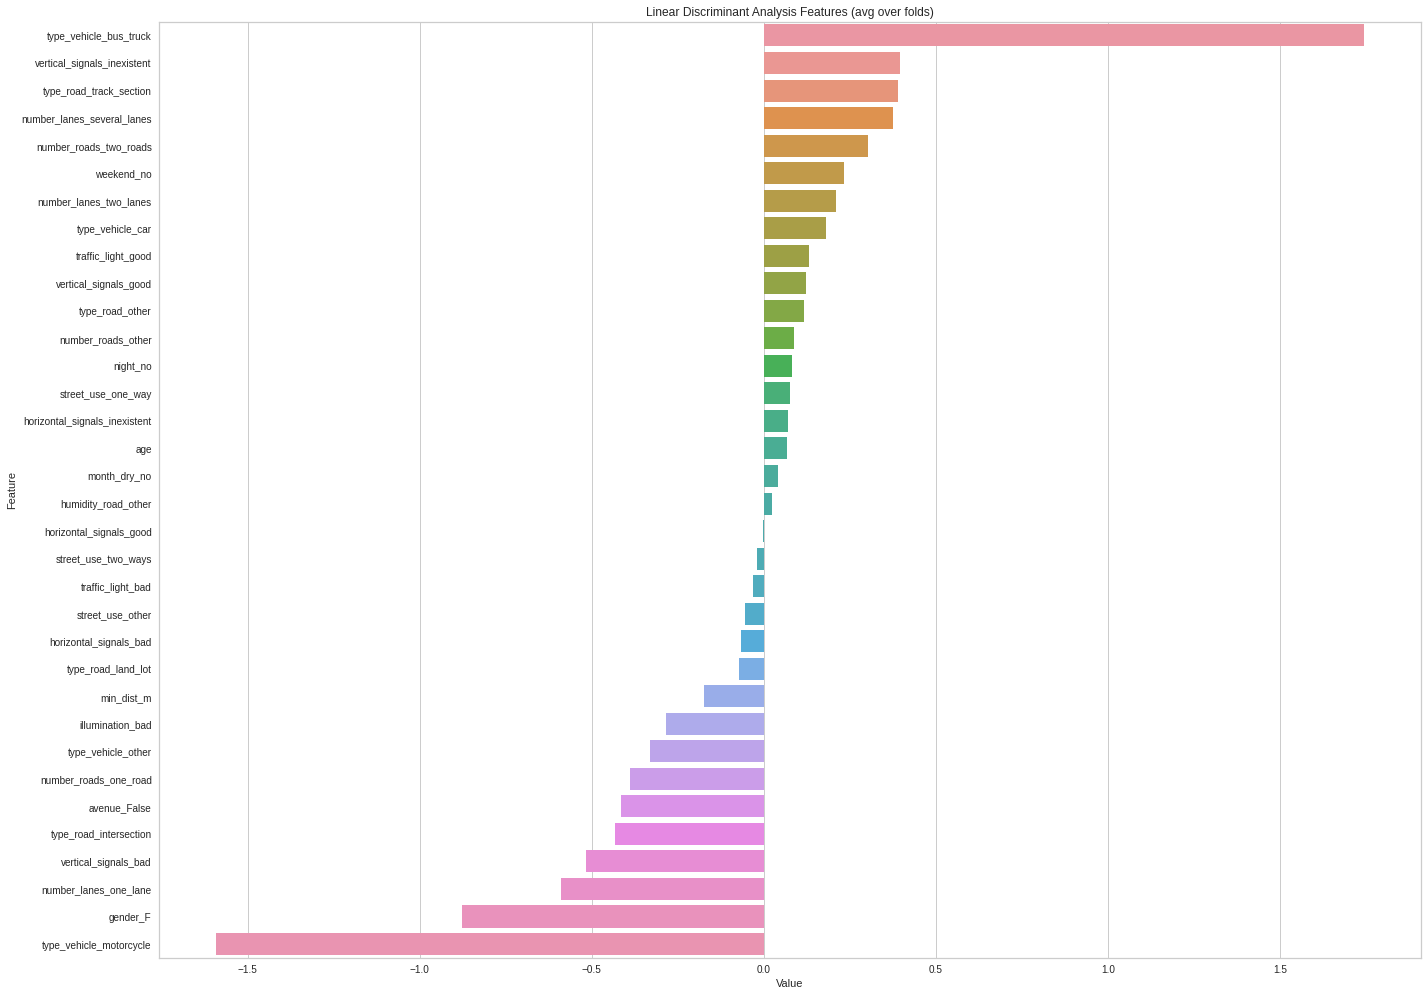

In [86]:
# interpreting model
feature_imp_tuned_lda = pd.DataFrame(sorted(zip(tuned_lda.coef_[0],get_config('X_train').columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 14))
sns.barplot(x="Value", y="Feature", data=feature_imp_tuned_lda.sort_values(by="Value", ascending=False))
plt.title('Linear Discriminant Analysis Features (avg over folds)')
plt.tight_layout()
plt.show()

In [114]:
col_names = ['age',
             'type_vehicle_bus_truck',
             'type_vehicle_motorcycle',
             'illumination_bad', 
             'gender_F', 
             'camera_land_use_public_space',
             'number_lanes_one_lane', 
             'vertical_signals_bad', 
             'type_road_intersection', 
             'avenue_False',
             'vertical_signals_inexistent', 
             'type_road_track_section', 
             'number_roads_one_road', 
             'number_lanes_several_lanes',
             'type_vehicle_other', 
             'number_roads_two_roads',
             'weekend_no', 
             'number_lanes_two_lanes', 
             'type_vehicle_car', 
             'min_dist_m', 
             'traffic_light_good', 
             'vertical_signals_good',
             'type_road_other', 
             'number_roads_other', 
             'night_no',
             'street_use_one_way', 
             'type_road_land_lot',
             'horizontal_signals_inexistent',
             'horizontal_signals_bad',
             'street_use_other', 
             'month_dry_no', 
             'traffic_light_bad',
             'humidity_road_other',
             'street_use_two_ways',
             'horizontal_signals_good'
            ]

In [115]:
coef_values = [2.16790519,
               1.742436,
               -1.5912454,
               0.88337535,
               -0.8776059,
               0.68337535,
               -0.58823013,
               -0.51755905,
               -0.43256855,
               -0.41435054,
               0.39510244,
               0.39034975,
               -0.38896865,
               0.375981,
               -0.33063075,
               0.30208927,
               0.23218721,
               0.20791708,
               0.17944011,
               -0.17411557,
               0.13147181,
               0.12245663,
               0.11601394,
               0.08687936,
               0.08225083,
               0.07638933,
               -0.07379513,
               0.07069402,
               -0.06677878,
               -0.055074,
               0.04121551,
               -0.03088269,
               0.0235409,
               -0.02131533,
               -0.00391524,  
              ]

In [116]:
tornado_plot = pd.DataFrame(data={'feat': col_names, 'coefs': coef_values})
tornado_plot

,feat,coefs
0,age,2.167905
1,type_vehicle_bus_truck,1.742436
2,type_vehicle_motorcycle,-1.591245
3,illumination_bad,0.823375
4,gender_F,-0.877606
5,number_lanes_one_lane,-0.588230
6,vertical_signals_bad,-0.517559
7,type_road_intersection,-0.432569
8,avenue_False,-0.414351
9,vertical_signals_inexistent,0.395102


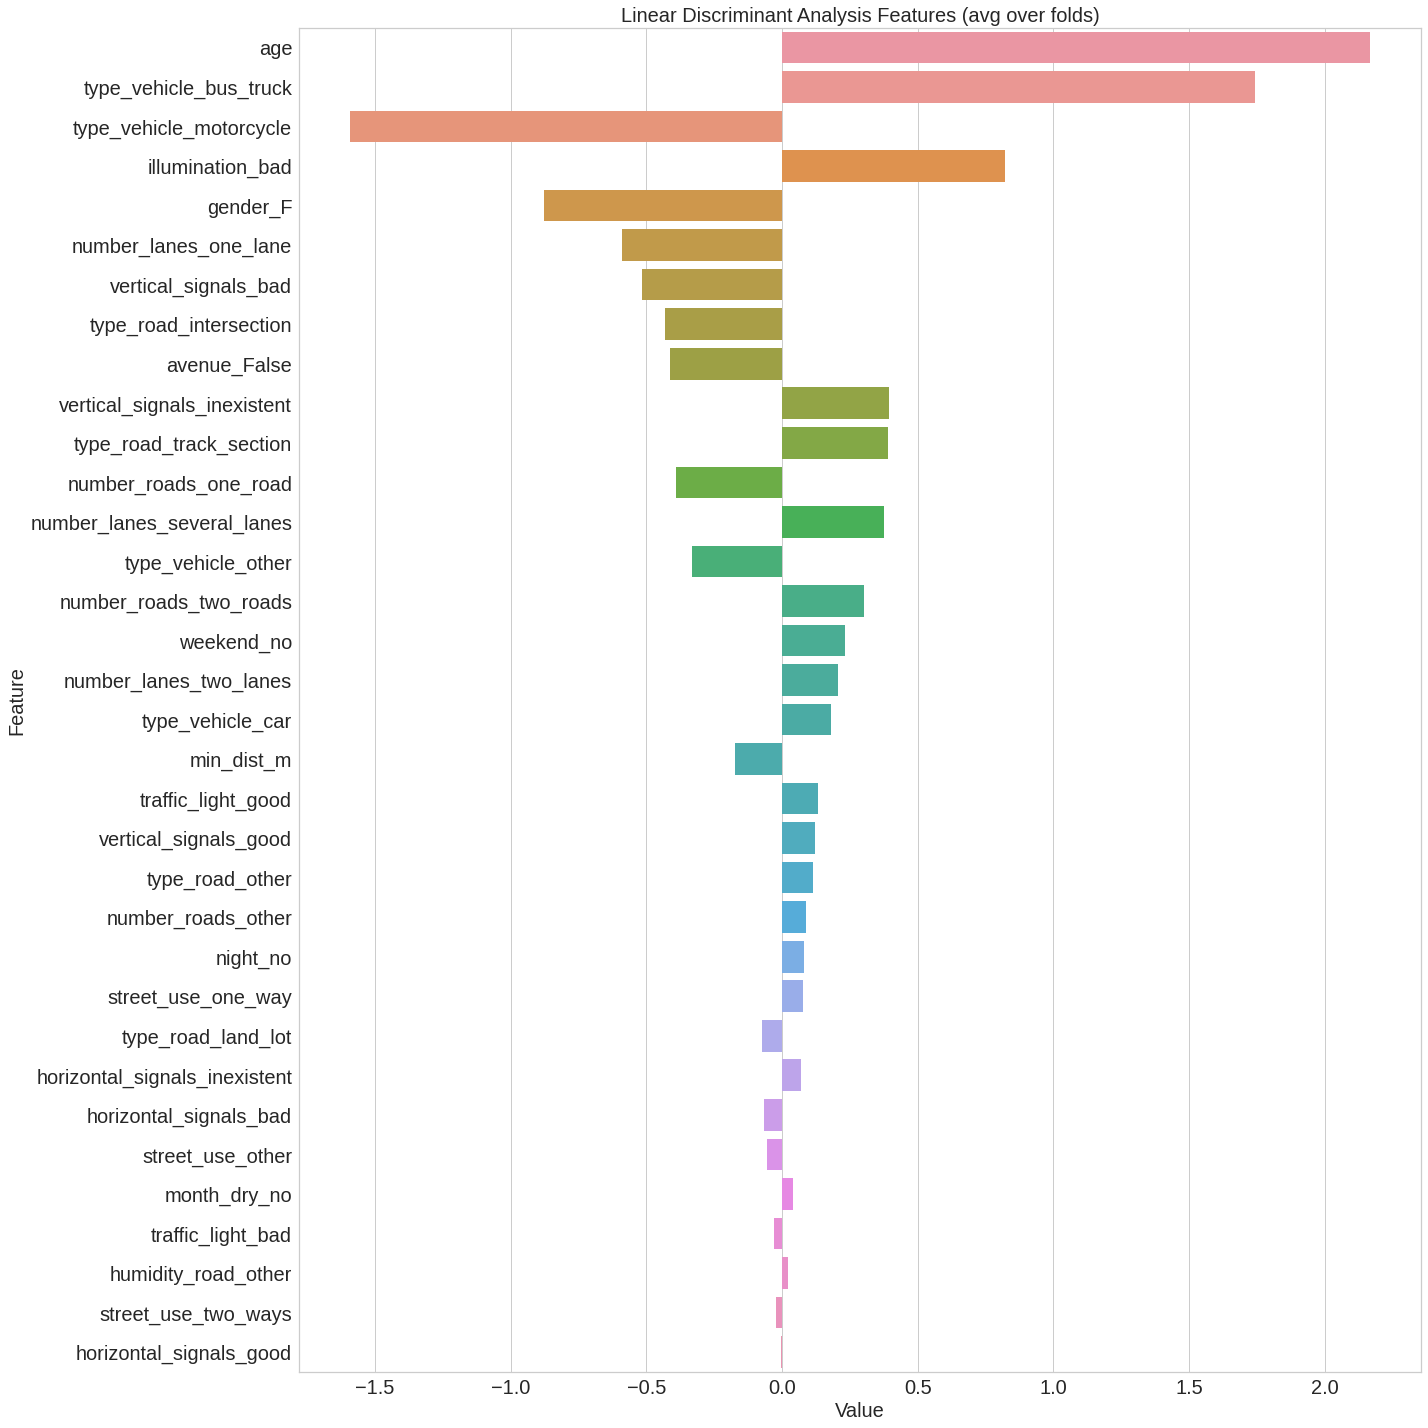

In [117]:
# interpreting model_reduced

fig = plt.figure(figsize=(20, 20))
sns.barplot(x='coefs', y='feat', data=tornado_plot)
plt.title('Linear Discriminant Analysis Features (avg over folds)', size = 20)
plt.xlabel('Value', size = 20)
plt.ylabel('Feature', size = 20)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.tight_layout()
fig.savefig('tornado.png')
plt.show()
